<a href="https://colab.research.google.com/github/RobBurnap/Bioinformatics-MICR4203-MICR5203/blob/main/Notebook/Markov_Phyolgenetic_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Non-Homogeneous CTMC on a Bifurcating Tree (ACGT)

This notebook builds a **toy phylogenetic example** where **different branches use different substitution models** (non-homogeneous across the tree).

We will:
1. Define rate matrices \(Q^{(1)}\) and \(Q^{(2)}\) for A,C,G,T (different base frequencies and transition/transversion bias).
2. Build a small binary tree (bifurcating) with branch-specific \(Q\) and branch lengths \(t\).
3. Compute transition probabilities \(P_b = e^{Q_b t_b}\) per branch.
4. Show the graphical tree, Q/P tables, and compute a single-site likelihood via Felsenstein's pruning using branch-specific \(P_b\).
5. Provide clear formulas, narrative, and code cells you can tweak for exercises.


## CTMC Primer

A **Continuous-Time Markov Chain (CTMC)** is the foundation for almost all phylogenetic substitution models.

- **States**: nucleotides (A,C,G,T) or amino acids.
- **Markov property**: next state depends only on the current state, not the past.
- **Continuous time**: substitutions can occur at any time along a branch.

### Rate Matrix (Q)

- Off-diagonals: $q_{ij}$ = instantaneous rate of substitution $i \to j$.
- Diagonals: $q_{ii} = -\sum_{j \ne i} q_{ij}$, so each row sums to 0.

**Symbolic form (states ordered A,C,G,T):**

$$
Q \;=\;
\begin{pmatrix}
q_{AA} & q_{AC} & q_{AG} & q_{AT} \\
q_{CA} & q_{CC} & q_{CG} & q_{CT} \\
q_{GA} & q_{GC} & q_{GG} & q_{GT} \\
q_{TA} & q_{TC} & q_{TG} & q_{TT}
\end{pmatrix},
\quad
q_{ii} = -\sum_{j \ne i} q_{ij}
$$

- Off-diagonals: $q_{ij}$ = instantaneous rate of substitution $i \to j$.
- Diagonals: $q_{ii} = -\sum_{j \ne i} q_{ij}$, so each row sums to 0.



### Transition Probabilities
$$
P(t) = e^{Qt}
$$
- $P_{ij}(t)$: probability that state $i$ becomes $j$ after time $t$.
- For very small $t$: $P(t) \to I$ (identity matrix).


In [11]:
from scipy.linalg import expm
from IPython.display import display, Math

def latex_matrix(M):
    return "\\begin{pmatrix}" + "\\\\".join([" & ".join(map(str, row)) for row in M]) + "\\end{pmatrix}"

def show_df(M, title=None, r=6):
    df = pd.DataFrame(np.round(M, r), index=states, columns=states)
    if title:
        print(title)
    display(df)
    return df

# Define Q using the hky_Q function
pi_demo = np.array([0.25, 0.25, 0.25, 0.25])  # Example base frequencies
kappa_demo = 2.0  # Example transition/transversion bias
Q, pi = hky_Q(pi_demo, kappa_demo)

t_demo = 0.5  # try 0.01, 0.1, 1.0
P = expm(Q * t_demo)

show_df(P, f"P(t={t_demo}) (rows sum ≈ 1)")
display(Math(latex_matrix(P)))

P(t=0.5) (rows sum ≈ 1)


,A,C,G,T
A,0.637816,0.098367,0.165449,0.098367
C,0.098367,0.637816,0.098367,0.165449
G,0.165449,0.098367,0.637816,0.098367
T,0.098367,0.165449,0.098367,0.637816


<IPython.core.display.Math object>

## General HKY Function

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import expm

states = ["A", "C", "G", "T"]
idx = {s: i for i, s in enumerate(states)}  # map symbols → indices

def hky_Q(pi, kappa):
    # Identify transition pairs by symbol, then convert to indices
    transition_pairs = [("A", "G"), ("G", "A"), ("C", "T"), ("T", "C")]
    transitions = [(idx[src], idx[dst]) for src, dst in transition_pairs]

    # Build relative-rate template: 1 for all substitutions, κ for transitions
    R = np.ones((4, 4))
    np.fill_diagonal(R, 0)  # ignore diagonal here
    for i, j in transitions:
        R[i, j] = kappa

    # HKY-like off-diagonals: Q_ij = R_ij * pi_j
    Q = R * pi[np.newaxis, :]
    np.fill_diagonal(Q, 0)
    np.fill_diagonal(Q, -Q.sum(axis=1))  # rows sum to 0

    rate = np.sum(pi * (-np.diag(Q)))
    Q /= rate
    return Q, pi

def df_mat(M, title=None, r=6):
    import pandas as pd
    df = pd.DataFrame(np.round(M, r), index=states, columns=states)
    if title:
        print(title)
    display(df)
    return df

def draw_tree(branches):
    xy = {
        "R": (0.0, 0.5),
        "X": (0.5, 0.75),
        "Y": (0.5, 0.25),
        "A": (1.0, 0.9),
        "B": (1.0, 0.6),
        "C": (1.0, 0.4),
        "D": (1.0, 0.1),
    }
    plt.figure(figsize=(7,3.5))
    for (u,v,t,label) in branches:
        x1,y1 = xy[u]; x2,y2 = xy[v]
        plt.plot([x1,x2],[y1,y2])
        midx, midy = (x1+x2)/2, (y1+y2)/2
        plt.text(midx, midy+0.03, f"t={t}", ha="center", va="bottom")
        plt.text(midx, midy-0.05, f"{label}", ha="center", va="top")
    for n,(x,y) in xy.items():
        plt.scatter([x],[y])
        plt.text(x, y+0.04, n, ha="center")
    plt.axis("off")
    plt.title("Binary tree with branch-specific models")
    plt.show()

def branch_transition(Q, t):
    return expm(Q * t)

## Binary Tree with Branch-Specific Models

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import expm

states = ["A", "C", "G", "T"]
idx = {s: i for i, s in enumerate(states)}  # map symbols → indices

def hky_Q(pi, kappa):
    # Identify transition pairs by symbol, then convert to indices
    transition_pairs = [("A", "G"), ("G", "A"), ("C", "T"), ("T", "C")]
    transitions = [(idx[src], idx[dst]) for src, dst in transition_pairs]

    # Build relative-rate template: 1 for all substitutions, κ for transitions
    R = np.ones((4, 4))
    np.fill_diagonal(R, 0)  # ignore diagonal here
    for i, j in transitions:
        R[i, j] = kappa

    # HKY-like off-diagonals: Q_ij = R_ij * pi_j
    Q = R * pi[np.newaxis, :]
    np.fill_diagonal(Q, 0)
    np.fill_diagonal(Q, -Q.sum(axis=1))  # rows sum to 0

    rate = np.sum(pi * (-np.diag(Q)))
    Q /= rate
    return Q, pi

def df_mat(M, title=None, r=6):
    import pandas as pd
    df = pd.DataFrame(np.round(M, r), index=states, columns=states)
    if title:
        print(title)
    display(df)
    return df

def draw_tree(branches):
    xy = {
        "R": (0.0, 0.5),
        "X": (0.5, 0.75),
        "Y": (0.5, 0.25),
        "A": (1.0, 0.9),
        "B": (1.0, 0.6),
        "C": (1.0, 0.4),
        "D": (1.0, 0.1),
    }
    plt.figure(figsize=(7,3.5))
    for (u,v,t,label) in branches:
        x1,y1 = xy[u]; x2,y2 = xy[v]
        plt.plot([x1,x2],[y1,y2])
        midx, midy = (x1+x2)/2, (y1+y2)/2
        plt.text(midx, midy+0.03, f"t={t}", ha="center", va="bottom")
        plt.text(midx, midy-0.05, f"{label}", ha="center", va="top")
    for n,(x,y) in xy.items():
        plt.scatter([x],[y])
        plt.text(x, y+0.04, n, ha="center")
    plt.axis("off")
    plt.title("Binary tree with branch-specific models")
    plt.show()

def branch_transition(Q, t):
    return expm(Q * t)

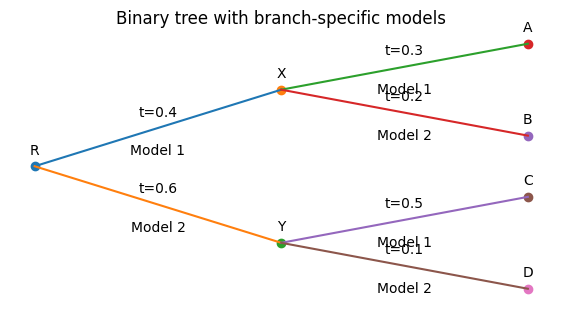

In [9]:

branches = [
    ("R","X",0.4,"Model 1"),
    ("R","Y",0.6,"Model 2"),
    ("X","A",0.3,"Model 1"),
    ("X","B",0.2,"Model 2"),
    ("Y","C",0.5,"Model 1"),
    ("Y","D",0.1,"Model 2"),
]
draw_tree(branches)



## Per-Branch Transition Probabilities
For each branch $b$ with model $Q_b$ and length $t_b$,
$$
P_b = e^{Q_b t_b}
$$



## Closing Notes: Models vs. Trees

In this notebook we explored how **Continuous-Time Markov Chains (CTMCs)** connect substitution *models* (Q matrices) with the *tree structure* of phylogenetics.  

### 1. What parameters do
- **π (base frequencies)** and **κ (transition/transversion bias)** control substitution probabilities.  
- **Branch length t** controls the expected number of substitutions per site.  
- These parameters **do not change the branching pattern** for a fixed topology.

### 2. What defines topology
- The **tree topology** comes from *search* (NNI, SPR, etc.) in programs like RAxML, IQ-TREE, MrBayes.  
- Likelihood is computed for each topology, and the best is chosen.

### 3. Interaction between model and topology
- Changing π, κ, or t changes branch lengths and likelihood values.  
- Different substitution models (JC, HKY, GTR) can prefer different topologies.

### 4. Suggested exercises
- Change κ in the step-by-step cell (e.g. κ=1 vs κ=10) and compare Q.  
- Change π (e.g. π_A=0.7) and see how Q changes.  
- Change t in P(t) and confirm that as t→0, P(t)→I.  
- Redraw the tree with different branch lengths.

---
**Key point:** Topology = who branches with whom. Parameters = how substitutions behave along those branches.
